In [6]:
from IPython.display import HTML
HTML("""<style>.container {width: 100% !important;}</style>""")

Deep Learning
=============

Assignment 1
------------
http://nbviewer.jupyter.org/github/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import urllib
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
import cPickle as pickle

### Machine Info:

In [1]:
%load_ext version_information

In [5]:
%version_information sklearn, numpy, scipy, matplotlib, tensorflow,

Software versions
Python 2.7.10 64bit [GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.0.72)]
IPython 4.1.1
OS Darwin 15.3.0 x86_64 i386 64bit
sklearn 0.17
numpy 1.10.4
scipy 0.17.0
matplotlib 1.5.1
tensorflow 0.6.0
cPickle 1.71
Mon Feb 15 22:43:53 2016 EST

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('assignment1/notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('assignment1/notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
num_classes = 10

def extract(filename):
#     tar = tarfile.open(filename)
#     tar.extractall()
#     tar.close()
#     root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    root = filename.split('.')[0] # remove .tar.gz
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if not d.startswith('.DS_Store')]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders))) 
    print data_folders
    return data_folders
  
train_folders = extract(train_filename)
test_folders = extract(test_filename)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
samples = []
a = train_folders[0]
for sample in os.listdir(a):
    samples.append(a + '/' + sample)

In [6]:
Image(samples[9])

In [7]:
Image(samples[6])

In [8]:
Image(samples[38])

Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

> Takes about ~3min 36s

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.


def load(data_folders, min_num_images, max_num_images):
    dataset = np.ndarray(shape=(max_num_images, image_size, image_size), dtype=np.float32)
    labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
    label_index = 0
    image_index = 0
    for folder in data_folders:
        print(folder)
        for image in os.listdir(folder):
            if image_index >= max_num_images:
                raise Exception('More images than expected: %d >= %d' % (num_images, max_num_images))
            image_file = os.path.join(folder, image)
            try:
                image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
                if image_data.shape != (image_size, image_size):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[image_index, :, :] = image_data
                labels[image_index] = label_index
                image_index += 1
            except IOError as e:
                print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
        label_index += 1
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    labels = labels[0:num_images]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    print 'Full dataset tensor:', dataset.shape
    print 'Mean:', np.mean(dataset)
    print 'Standard deviation:', np.std(dataset)
    print 'Labels:', labels.shape
    return dataset, labels

train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)


notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
notMNIST_large/C
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
notMNIST_large/E
notMNIST_large/F
notMNIST_large/G
notMNIST_large/H


Now lets take a look

In [10]:
print(train_labels.shape, 'and', train_dataset.shape)

(529114,) and (529114, 28, 28)


529114 sample images, each image is a 28 x 28 pixels. 
That is, 28 arrays each of length 28

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [58]:
letters = list('ABCDEFGHIJ')
letters = {i:c for i,c in zip(set(train_labels), letters) }
print(letters)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}


#### Plotting the converted letters from ndarray

In [12]:
def plot_img_from_ndarray(sample_indices):
    fig, ax = plt.subplots(1,len(sample_indices), figsize=(8, 2))
    for i, j in enumerate(sample_indices):
        ax[i].imshow(train_dataset[j], interpolation='nearest')   
        ax[i].set_title(letters[train_labels[j]])
    plt.show()

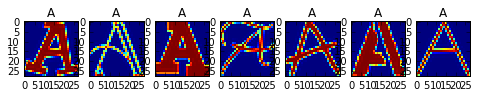

In [16]:
plot_img_from_ndarray(range(1000,1007))

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [17]:
np.random.seed(133)
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

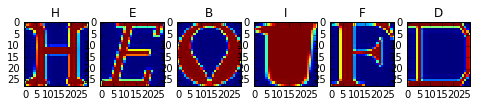

In [18]:
plot_img_from_ndarray(range(1000,1006))

---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [19]:
# train data samples
for class_ in set(train_labels):
    print letters[class_], len(train_dataset[ train_labels == class_]), '  ',

A 52909    B 52911    C 52912    D 52911    E 52912    F 52912    G 52912    H 52912    I 52912    J 52911   


In [20]:
# labels
for class_ in set(train_labels):
    print letters[class_], len(train_labels[ train_labels == class_]), '  ',

A 52909    B 52911    C 52912    D 52911    E 52912    F 52912    G 52912    H 52912    I 52912    J 52911   


Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [22]:
train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]
print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape

Training (200000, 28, 28) (200000,)
Validation (10000, 28, 28) (10000,)


Finally, let's save the data for later reuse:

In [23]:
pickle_file = 'assignment1/notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print 'Unable to save data to', pickle_file, ':', e
    raise

In [24]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size: {} megabyte'.format(statinfo.st_size / 1024. / 1024.)

Compressed pickle size: 684.922982216 megabyte


### Load the converted images data and start training
---

In [7]:
with open(r'assignment1/notMNIST.pickle', 'rb') as pfile:
    notMNIST = pickle.load(pfile)

In [8]:
for k in sorted(notMNIST.keys()):
    print('{} {}'.format(len(notMNIST[k]), k))

18724 test_dataset
18724 test_labels
200000 train_dataset
200000 train_labels
10000 valid_dataset
10000 valid_labels


In [9]:
train_dataset = notMNIST['train_dataset']
train_labels = notMNIST['train_labels']
valid_dataset = notMNIST['valid_dataset']
valid_labels  = notMNIST['valid_labels']
test_dataset = notMNIST['test_dataset']
test_labels = notMNIST['test_labels']

---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is **between training, validation and test** samples.
Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [96]:
def train(X, y, train_size=1000, test_sample_size=2000):
    
    s1 = train_size
    s2 = test_sample_size
    
    # training sample
    X_s = X[:s1].reshape(s1,28*28)
    y_s = y[:s1]
    
    # test sample (small batch of the unseen-yet train_dataset)
    X_test = X[s1:s1+s2].reshape(s2, 28*28)
    y_test = y[s1:s1+s2]
    
    # Init Classifier
    logit = LogisticRegression()
    
    # fit the model
    logit.fit(X_s, y_s)
    
    # performance
    score = logit.score(X_test, y_test)
    
    # result
    print('trained on: \t{} samples'.format(train_size))
    print('tested on: \t{} samples'.format(test_sample))
    print('accuracy: \t{:.1f}%\n\n'.format(score * 100))
    
    return logit

Training on 50, 100, 1000 and 5000 sample

In [31]:
logit50 = train(train_dataset, train_labels, 5, 100)

trained on: 	5 samples
tested on: 	100 samples
accuracy: 	14.0%




In [32]:
logit100 = train(train_dataset, train_labels, 100, 400)

trained on: 	100 samples
tested on: 	400 samples
accuracy: 	67.8%




In [33]:
logit1K = train(train_dataset, train_labels, 1000, 500)

trained on: 	1000 samples
tested on: 	500 samples
accuracy: 	75.4%




In [34]:
%%time
logit5K = train(train_dataset, train_labels, 5000, 800)

trained on: 	5000 samples
tested on: 	800 samples
accuracy: 	76.1%


CPU times: user 22 s, sys: 61.1 ms, total: 22 s
Wall time: 22 s


Lets try on more samples

In [35]:
%%time
logit10K = train(train_dataset, train_labels, 10000, 1000)

trained on: 	10000 samples
tested on: 	1000 samples
accuracy: 	76.9%


CPU times: user 57.3 s, sys: 502 ms, total: 57.8 s
Wall time: 59 s


In [37]:
%%time
logit30K = train(train_dataset, train_labels, 30000, 5000)

trained on: 	30000 samples
tested on: 	5000 samples
accuracy: 	81.2%


CPU times: user 3min 45s, sys: 941 ms, total: 3min 46s
Wall time: 3min 46s


In [38]:
%%time
logit100K = train(train_dataset, train_labels, 100000, 20000)

trained on: 	100000 samples
tested on: 	20000 samples
accuracy: 	82.2%


CPU times: user 13min 44s, sys: 2.43 s, total: 13min 46s
Wall time: 13min 48s


In [39]:
%%time
logit150K = train(train_dataset, train_labels, 150000, 50000)

trained on: 	150000 samples
tested on: 	50000 samples
accuracy: 	82.2%


CPU times: user 21min 48s, sys: 7.68 s, total: 21min 56s
Wall time: 22min 10s


In [97]:
%%time
logit180K = train(train_dataset, train_labels, 180000, 20000)

trained on: 	180000 samples
tested on: 	20000 samples
accuracy: 	82.1%


CPU times: user 26min 33s, sys: 10.8 s, total: 26min 43s
Wall time: 27min 24s


#### Save this awesome `LogisticRegression` model 

In [4]:
model_name = 'assignment1/logitModel.pickle'

In [6]:
pickle.dump(logit180K, open(model_name, 'wb'))

#### Load the saved model

In [7]:
with open(model_name, 'rb') as m:
    model = pickle.load(m)

#### Lets use it on the validation dataset

In [10]:
valid_dataset.shape

(10000, 28, 28)

In [11]:
X = valid_dataset
y = valid_labels
X_test = X.reshape(len(X), 28*28)
y_test = y

model.score(X_test, y_test)

0.82099999999999995

#### Finally lets see how our model performs on the test set

In [12]:
test_dataset.shape

(18724, 28, 28)

In [13]:
X = test_dataset
y = test_labels
X_test = X.reshape(len(X), 28*28)
y_test = y

logit.score(X_test, y_test)

0.8920102542191839

### Note:
> it's odd that the model performs a lot better on the test set `89.2%` !! perhaps because of the overlapping ?

--- 
Sample Results

---

In [16]:
sample = test_dataset[:30]
labels = test_labels[:30]
pred = logit.predict(sample.reshape(len(sample), 28*28))
result = labels - pred
print 'predicted:', pred
print 'actual   :', labels
print 'result   : ', ' '.join(['-' if r == 0 else 'x' for r in result])

predicted: [7 9 6 0 1 1 2 5 5 8 2 1 7 0 3 3 9 1 0 9 2 5 4 4 5 9 2 4 1 0]
actual   : [3 9 6 0 1 1 2 5 5 8 2 1 7 0 3 3 8 1 7 9 2 5 4 4 5 8 2 1 1 0]
result   :  x - - - - - - - - - - - - - - - x - x - - - - - - x - x - -
